<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Илья Барышников (@lucidyan), Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №2
## <center> Визуальный анализ данных о сердечно-сосудистых заболеваниях

**В задании предлагается с помощью визуального анализа ответить на несколько вопросов по данным о сердечно-сосудистых заболеваниях. Данные использовались в соревновании [ML Boot Camp 5](http://mlbootcamp.ru/round/12/sandbox/) (качать их не надо, они уже есть в репозитории).**

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1WBYEAYlgOhqAJyh_e3udmBWpBbkpyFSrFCMlWAoRFTY/edit). Код отправлять никуда не нужно.**

В соревновании предлагалось определить наличие/отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам осмотра пациента.

**Описание данных.**

Датасет сформирован из реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:

 - Возраст (age)
 - Рост (height)
 - Вес (weight)
 - Пол (gender)
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
 - Холестерин (cholesterol)
 - Глюкоза (gluc)
 

Субъективные признаки (со слов пациентов):

 - Курение (smoke)
 - Употребление алкоголя (alco)
 - Физическая активность (active)
 
Целевой признак (который интересно будет прогнозировать):
 - Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

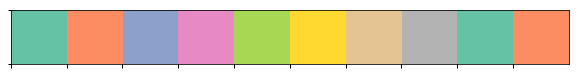

In [1]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# игнорируем warnings
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)
sns.palplot(sns.color_palette("Set2", 10))

---

В рамках задания для простоты будем работать только с обучающей выборкой. Чистить данные от выбросов и ошибок в данных НЕ нужно, кроме тех случаев, где об этом явно указано.
<br>
<br>
Все визуализации рекомендуем производить с помощью библиотеки `Seaborn`.

# Проведем небольшой EDA

In [2]:
train = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';',
                    index_col='id')

In [3]:
print('Размер датасета: ', train.shape)
train.head()

Размер датасета:  (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Для начала всегда неплохо бы посмотреть на значения, которые принимают переменные.

Переведем данные в "Long Format"-представление и отрисуем с помощью [factorplot](https://seaborn.pydata.org/generated/seaborn.factorplot.html) количество значений, которые принимают категориальные переменные.

In [4]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])

print(train_uniques.groupby(['variable', 'value'])['value'], '\n')
grouped_values = train_uniques.groupby(['variable', 'value'])['value'].count()
print(grouped_values.head(3), '\n')
train_uniques = pd.DataFrame(grouped_values) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
print(train_uniques.head())


variable  value
active    0        13739
          1        56261
alco      0        66236
Name: value, dtype: int64 

  variable  value  count
0   active      0  13739
1   active      1  56261
2     alco      0  66236
3     alco      1   3764
4   cardio      0  35021


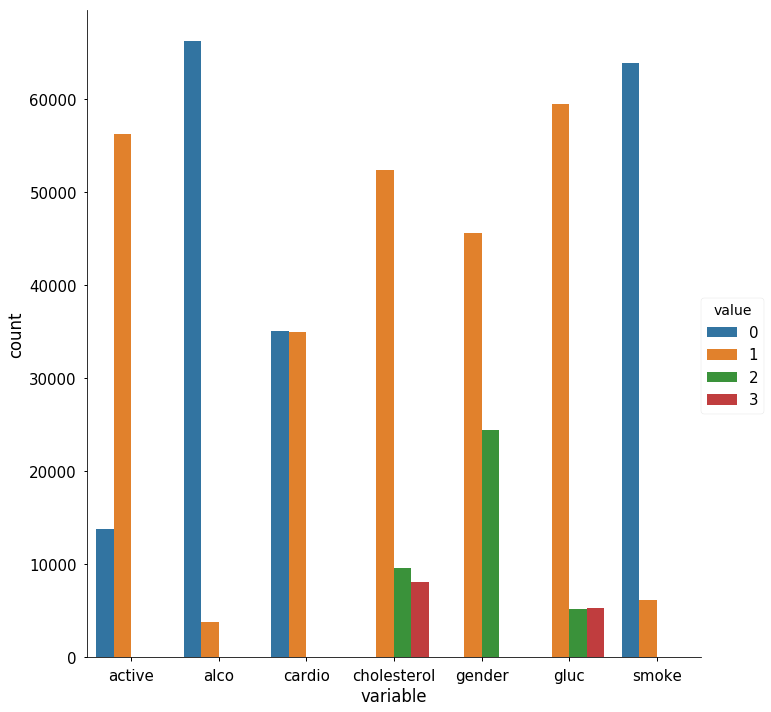

In [5]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])

grouped_values = train_uniques.groupby(['variable', 'value'])['value'].count()

train_uniques = pd.DataFrame(grouped_values) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               data=train_uniques, kind='bar', size=10);

Видим, что классы целевой переменной `cardio` сбалансированы, отлично!

Можно также разбить элементы обучающей выборки по значениям целевой переменной: иногда на таких графиках можно сразу увидеть самый значимый признак.

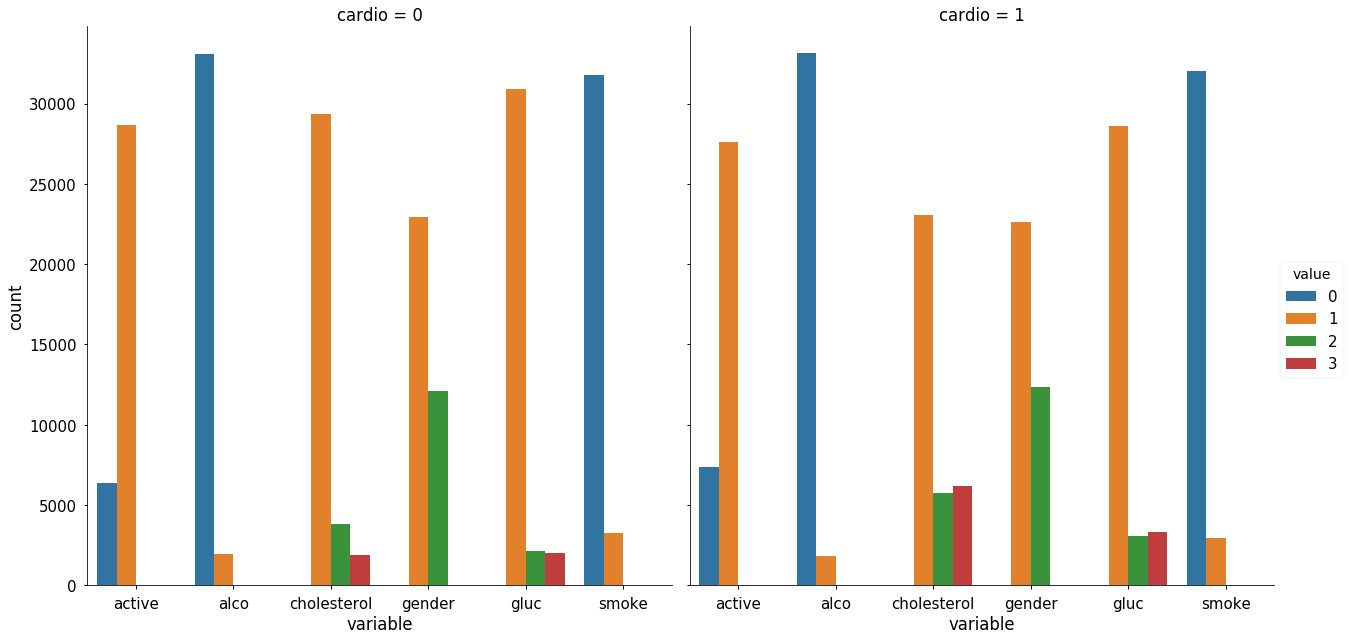

In [6]:
train_uniques = pd.melt(frame=train, 
                        value_vars=['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active'], 
                        id_vars=['cardio'])

train_uniques = pd.DataFrame(train_uniques.groupby(
    ['variable', 'value', 'cardio']
)['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=train_uniques, kind='bar', size=9);

Видим, что в зависимости от целевой переменной сильно меняется распределение холестерина и глюкозы. Совпадение?

**Немного статистики по уникальным значениям признаков.**

In [7]:
train.gender.nunique()
train['gender'].value_counts()
train['gender'].value_counts().to_dict().items()

dict_items([(1, 45530), (2, 24470)])

In [8]:
for c in train.columns:
    n = train[c].nunique()
    print(c)
    
    if n <= 3:
        column_counts = train[c].value_counts()
        print(n, sorted(column_counts.to_dict().items()))
    else:
        print(n)
    print(10 * '-')

age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


*Итого:*
- Пять количественных признаков (без id)
- Семь категориальных
- 70000 объектов

---

# 1. Визуализируем корреляционную матрицу

Для того чтобы лучше понять признаки в датасете, можно посчитать матрицу коэффициентов корреляции между признаками. <br>

Постройте [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) корреляционной матрицы. Матрица формируется средствами `Pandas`, со стандартным значением параметров.

###  1. Какие два признака больше всего коррелируют (по Пирсону) с признаком `height` ?

- Gluc, Cholesterol
- Weight, Alco
- Smoke, Alco
- Weight, Gender

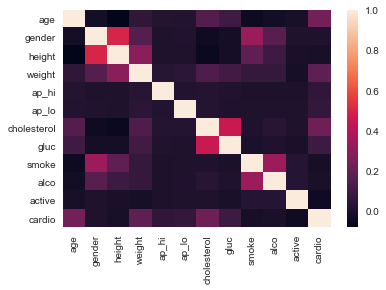

In [24]:
sns.heatmap(train.corr())
# Больше всего коррелируют с HEIGHT
# gender, weight

In [10]:
train.corr()['height'].abs().sort_values().tail(3)

weight    0.290968
gender    0.499033
height    1.000000
Name: height, dtype: float64

### Ответ: WEIGHT, HEIGHT

# 2. Распределение роста для мужчин и женщин

Как мы увидели, в процессе исследования уникальных значений пол кодируется значениями 1 и 2, расшифровка изначально не была нам дана в описании данных, но мы догадались, кто есть кто, посчитав средние значения роста (или веса) при разных значениях признака `gender`. Теперь сделаем то же самое, но графически. 

Постройте [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) для роста и пола. Используйте:
- hue – для разбивки по полу
- scale – для оценки количества каждого из полов 

Для корректной отрисовки, преобразуйте DataFrame в "Long Format"-представление с помощью функции melt в pandas.
<br>
[еще один пример](https://stackoverflow.com/a/41575149/3338479)

   gender variable  value  count
0       1   height     55      1
1       1   height     57      1
2       1   height     59      1


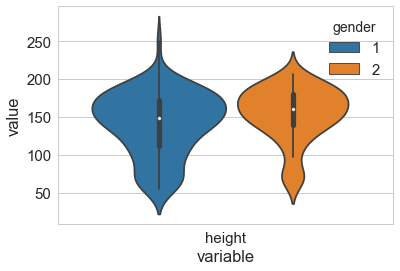

In [11]:
heights_melted = pd.melt(train, id_vars='gender', value_vars=['height'])
heights_grouped = heights_melted.groupby(['gender', 'variable', 'value'])['value'].count()

heights_frame = pd.DataFrame(heights_grouped).sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
print(heights_frame.head(3))

sns.set_style("whitegrid")
sns.violinplot(x='variable', y='value', hue='gender', scale='count', data=heights_frame);

Постройте на одном графике два отдельных [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) роста, отдельно для мужчин и женщин. На нем разница будет более наглядной, но нельзя будет оценить количество мужчин/женщин.

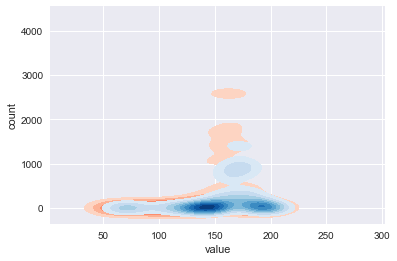

In [12]:
females_weights = heights_frame.loc[heights_frame.gender == 1, ['variable', 'value', 'count']]
males_weights = heights_frame.loc[heights_frame.gender == 2, ['variable', 'value', 'count']]

sns.set(color_codes=True)
ax = sns.kdeplot(females_weights['value'], females_weights['count'], cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(males_weights['value'], males_weights['count'], cmap="Blues", shade=True, shade_lowest=False)

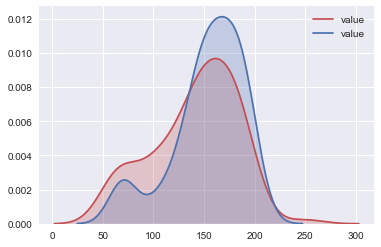

In [13]:
ax = sns.kdeplot(females_weights['value'], shade=True, color="r")
ax = sns.kdeplot(males_weights['value'], shade=True, color="b")

---

# 3. Ранговая корреляция

В большинстве случаев достаточно воспользоваться линейным коэффициентом корреляции *Пирсона* для выявления закономерностей в данных, но мы пойдём чуть дальше и используем ранговую корреляцию, которая поможет нам выявить пары, в которых меньший ранг из вариационного ряда одного признака всегда предшествует большему другого (или наоборот, в случае отрицательной корреляции).

##### Постройте корреляционную матрицу, используя коэффициент Спирмена

### 3.1 Какие признаки теперь больше всего коррелируют (по Спирмену) друг с другом?

- Height, Weight
- Age, Weight
- Ap_hi, Ap_lo
- Cholesterol, Gluc
- Cardio, Cholesterol
- Smoke, Alco

Коэффициент корреляции рангов, предложенный К. Спирменом, относится к непараметрическим показателям связи между переменными, измеренными в ранговой шкале. При расчете этого коэффициента не требуется никаких предположений о характере распределений признаков в генеральной совокупности. Этот коэффициент определяет степень тесноты связи порядковых признаков, которые в этом случае представляют собой ранги сравниваемых величин.

Величина коэффициента корреляции Спирмена также лежит в интервале +1 и -1. Он, как и коэффициент Пирсона, может быть положительным и отрицательным, характеризуя направленность связи между двумя признаками, измеренными в ранговой шкале.

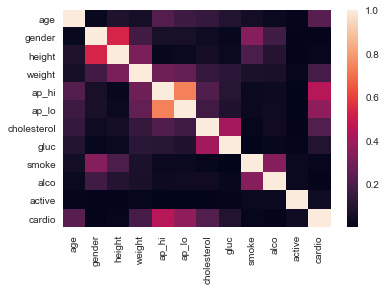

In [36]:
# Spearman rank correlation (более устойчивый к выбросам)
sns.heatmap(train.corr('spearman').abs())
# ap_hi, ap_lo

In [33]:
train.loc[:5, ['ap_hi', 'ap_lo']]

,ap_hi,ap_lo
id,,
0,110,80
1,140,90
2,130,70
3,150,100
4,100,60


In [35]:
train.corr('spearman').abs()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,0.020176,0.082292,0.061559,0.219087,0.156700,0.140113,0.091791,0.047471,0.030078,0.010422,0.234429
gender,0.020176,1.000000,0.533805,0.172480,0.063174,0.066374,0.035730,0.018866,0.338135,0.170966,0.005866,0.008109
height,0.082292,0.533805,1.000000,0.313569,0.019381,0.030534,0.058940,0.024369,0.197632,0.096670,0.007367,0.012383
weight,0.061559,0.172480,0.313569,1.000000,0.277749,0.254420,0.137908,0.109901,0.071676,0.068088,0.014894,0.182701
ap_hi,0.219087,0.063174,0.019381,0.277749,1.000000,0.735436,0.208722,0.105334,0.028929,0.033243,0.001268,0.451885
ap_lo,0.156700,0.066374,0.030534,0.254420,0.735436,1.000000,0.167401,0.082474,0.026172,0.038862,0.003401,0.362572
cholesterol,0.140113,0.035730,0.058940,0.137908,0.208722,0.167401,1.000000,0.407803,0.015220,0.041285,0.007573,0.215117
gluc,0.091791,0.018866,0.024369,0.109901,0.105334,0.082474,0.407803,1.000000,0.000468,0.018584,0.008610,0.091488
smoke,0.047471,0.338135,0.197632,0.071676,0.028929,0.026172,0.015220,0.000468,1.000000,0.340094,0.025858,0.015486
alco,0.030078,0.170966,0.096670,0.068088,0.033243,0.038862,0.041285,0.018584,0.340094,1.000000,0.025476,0.007330


### ответ: ap_hi, ap_lo

### 3.2 Почему мы получили такое большое (относительно) значение ранговой корреляции у этих признаков?

- Неточности в данных (ошибки при сборе данных)
- Связь ошибочна, переменные никак не должны быть связаны друг с другом
- Природа данных

---

# 4. Совместное распределение признаков

Постройте совместный график распределения [jointplot](http://seaborn.pydata.org/generated/seaborn.jointplot.html) двух наиболее коррелирующих между собой признаков (по Спирмену).


Кажется, наш график получился неинформативным из-за выбросов в значениях. Постройте тот же график, но с логарифмической шкалой (чтобы не получать OverflowError необходимо отфильтровать значения меньше либо равные нулю).

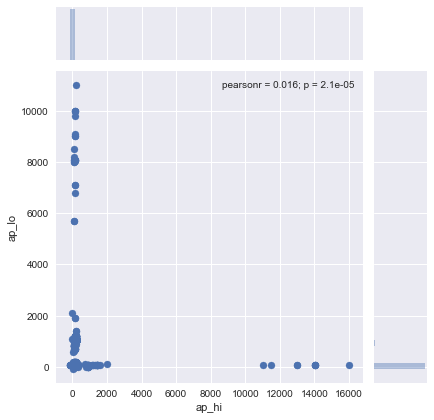

In [46]:
# обыяный joinplot
sns.jointplot('ap_hi', 'ap_lo', data=train);

In [51]:
# Выбросы, еще и NaN присутствует
print(train.ap_hi.sort_values().head(3), train.ap_hi.sort_values().tail(3))
print(train.ap_lo.sort_values().head(3), train.ap_lo.sort_values().tail(3));

id
50055   -150
34295   -140
66571   -120
Name: ap_hi, dtype: int64 id
36414    14020
66998    14020
58374    16020
Name: ap_hi, dtype: int64
id
85816   -70
57646     0
60565     0
Name: ap_lo, dtype: int64 id
34098    10000
3352     10000
61901    11000
Name: ap_lo, dtype: int64


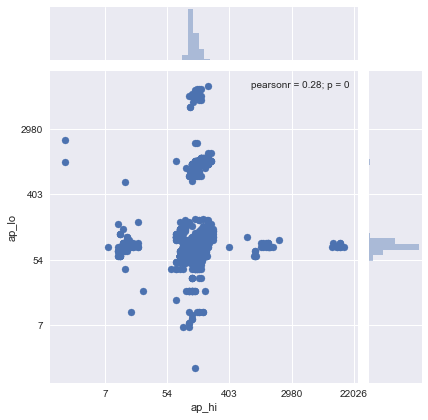

In [72]:
# Ваш код здесь
# убираю NaN, значения <= 0
filtered_ejection = train[(train.ap_lo > 0) & (train.ap_hi > 0)][['ap_lo', 'ap_hi']].dropna().copy()

filtered_ejection.ap_hi = filtered_ejection.ap_hi.apply(np.log1p, );
filtered_ejection.ap_lo = filtered_ejection.ap_lo.apply(np.log1p);

g = sns.jointplot(filtered_ejection.ap_hi, filtered_ejection.ap_lo)
# -------------------- #

"""Сетка"""
g.ax_joint.grid(True) 

"""Преобразуем логарифмические значения на шкалах в реальные"""
g.ax_joint.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, pos: str(round(int(np.exp(y))))))
g.ax_joint.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))

### 4.1 Сколько чётко выраженных кластеров получилось на  совместном графике выбранных признаков, с логарифмической шкалой? Под кластером в данной задаче понимается плотное скопление точек, в окрестности которого пренебрежительно мало одиночных наблюдений и которое визуально отделимо от других кластеров.

- 1
- 2
- 3
- больше трёх

### Ответ 3: т.к. вверху и справа видны выбросы

---

# 5. Возраст

Посчитаем, сколько полных лет было респондентам на момент их занесения в базу.

In [74]:
train['age_years'] = (train['age'] // 365.25).astype(int)

Постройте [Countplot](http://seaborn.pydata.org/generated/seaborn.countplot.html), где на оси абсцисс будет отмечен возраст, на оси ординат – количество. Каждое значение возраста должно иметь два столбца, соответствующих количеству человек каждого класса **cardio** (здоров/болен) данного возраста.

### 5. В каком возрасте количество пациентов с ССЗ  впервые становится больше, чем здоровых?
- 44
- 49
- 53
- 62

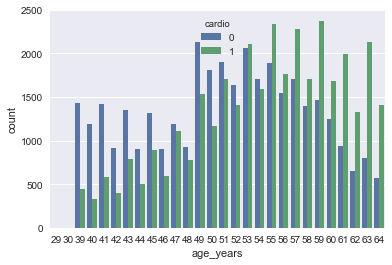

In [77]:
sns.countplot('age_years', hue='cardio', data=train)

### Ответ 53